In [1]:
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

ModuleNotFoundError: No module named 'torch'

In [5]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
train_data = torchvision.datasets.CIFAR10(root='./data',train=True, transform=transform,download=True)
test_data = torchvision.datasets.CIFAR10(root='./data',train=False, transform=transform,download=True)

In [7]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=132, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=132, shuffle=True, num_workers=2)

In [8]:
image, label = train_data[0]

In [9]:
image.size()

torch.Size([3, 32, 32])

In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())  # Returns current device index
print(torch.cuda.device_count())    # Number of available GPUs
print(torch.cuda.get_device_name(0))  # Name of the GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


True


In [11]:
class_names = ['plane', "car", "bird", 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [12]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(48)
        self.bn3 = nn.BatchNorm2d(32)
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)  # Output: (64, 28, 28)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (64, 14, 14)
        self.conv2 = nn.Conv2d(64, 48, kernel_size=5)  # Output: (48, 10, 10) -> (48, 5, 5) after pooling
        self.conv3 = nn.Conv2d(48, 32, kernel_size=3)  # Output: (32, 3, 3) -> (32, 1, 1) after pooling

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 1 * 1, 120)  # Adjusted input size after conv3
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.fc4 = nn.Linear(10, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Conv1 -> BatchNorm -> ReLU -> Pool
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Conv2 -> BatchNorm -> ReLU -> Pool
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Conv3 -> BatchNorm -> ReLU -> Pool
        x = torch.flatten(x, 1)  # Flatten the tensor
        x = F.relu(self.fc1(x))  # Fully connected layer 1
        x = F.relu(self.fc2(x))  # Fully connected layer 2
        x = self.fc3(x)  # Fully connected layer 3
        return x


In [17]:
net = NeuralNet().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [18]:
for epoch in range(20) :
    print("Training epoch : " + str(epoch))

    running_loss = 0.0

    for i, data in enumerate(train_loader) :
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)

        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print("Loss : " + str(running_loss/len(train_loader)))

Training epoch : 0
Loss : 1.6710769013553308
Training epoch : 1
Loss : 1.287219979832229
Training epoch : 2
Loss : 1.158880434124325
Training epoch : 3
Loss : 1.0877232886555956
Training epoch : 4
Loss : 1.0300434579320823
Training epoch : 5
Loss : 0.9805348501356422
Training epoch : 6
Loss : 0.9515277052932175
Training epoch : 7
Loss : 0.9225046898884635
Training epoch : 8
Loss : 0.8966245041044533
Training epoch : 9
Loss : 0.8755440101774513
Training epoch : 10
Loss : 0.8566193151285277
Training epoch : 11
Loss : 0.8417012766986535
Training epoch : 12
Loss : 0.8229952703050699
Training epoch : 13
Loss : 0.8198644838106663
Training epoch : 14
Loss : 0.8118776296877295
Training epoch : 15
Loss : 0.7962328453491734
Training epoch : 16
Loss : 0.7865730447001696
Training epoch : 17
Loss : 0.7751447995608589
Training epoch : 18
Loss : 0.7646617423890448
Training epoch : 19
Loss : 0.7629022132752753


In [19]:
torch.save(net.state_dict(), 'trained_net.pth')

In [20]:
net = NeuralNet().to(device)
net.load_state_dict(torch.load('trained_net.pth'))

<All keys matched successfully>

In [ ]:
correct = 0
total = 0

net.eval()

with torch.no_grad() :
    for data in test_loader :
        images, labels = data
        images, labels =  images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print("Accuracy = " + str(accuracy))

# 30 epochs = 71% accuracy
     

Accuracy = 71.31


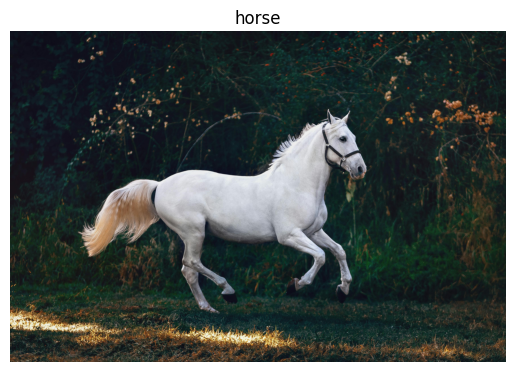

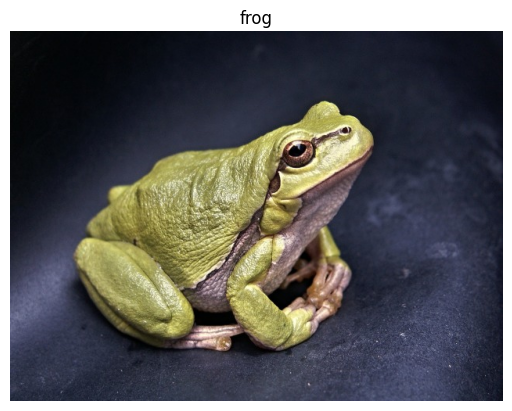

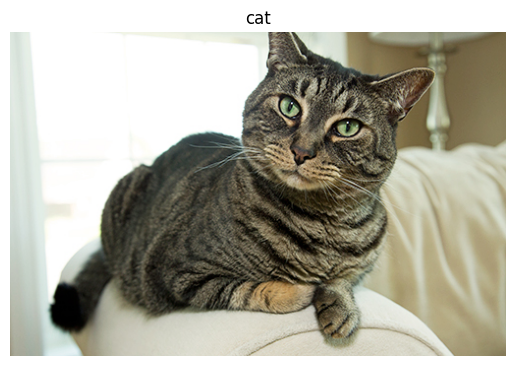

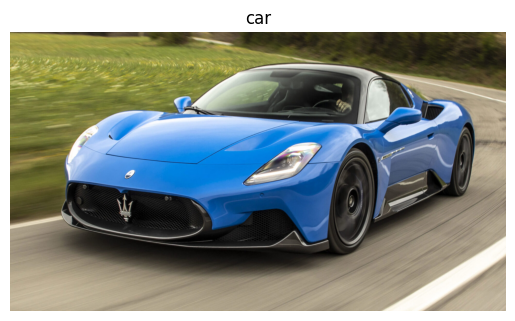

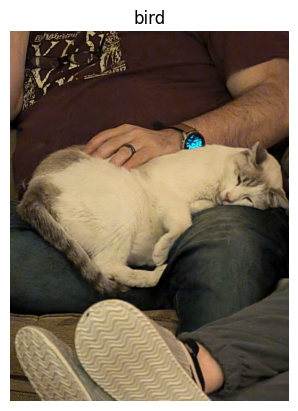

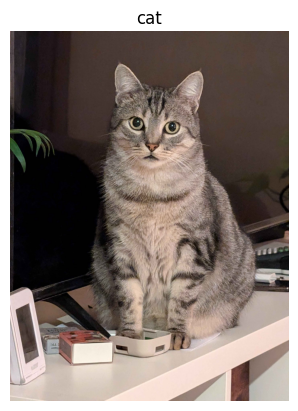

In [29]:
# TEST WITH ACTUAL IMAGES

new_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


def load_images(image_path):
    original_image = Image.open(image_path).convert('RGB')
    transformed_image = new_transform(original_image).unsqueeze(0)
    return original_image, transformed_image

image_paths = ['Horse.jpg','Frog.jpg','Chat.jpg','Car.jpg','Charlie.png','Raptor.png']
images = [load_images(img) for img in image_paths]

net.eval()
with torch.no_grad() :
    for original_image,image in images :
        image =  image.to(device)
        output = net(image)
        _, predicted = torch.max(output, 1)
        plt.imshow(original_image)
        plt.title(class_names[predicted.item()])
        plt.axis('off')
        plt.show()